In [43]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Rescaling, Conv2D, \
                                    Dropout, MaxPooling2D,\
                                    Flatten, Dense, ReLU, Lambda
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [16]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
    
!nvidia-smi

Tue Mar 18 00:43:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  |   00000000:06:00.0  On |                  N/A |
| 52%   42C    P0             49W /  215W |    1735MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
width = 200
height = 150
channels = 1
input_shape = (height, width, channels)

## Load image pairs dataset

* X_siam.npy and y_siam.npy are the original inputs for the siamese-network 

In [18]:
def load_data():
    X = np.load("X_siam.npy")
    print(X.shape)
    y = np.load("y_siam.npy")
    print(y.shape)

    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    print(X_t.shape)
    print(y_t.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size = 0.2, random_state = 42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    del X_t
    del y_t

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

MemoryError: Unable to allocate 13.6 GiB for an array with shape (1821600000,) and data type float64

## Data visualization

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


### Visualize train data

Index to show: 14805
Index to show: 2432
Index to show: 14172
Index to show: 8426


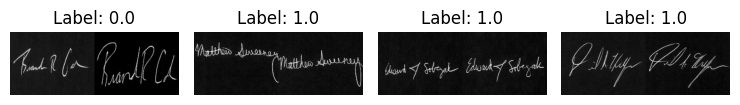

In [ ]:
visualize(X_train[:-1], y_train[:-1], to_show = 4, num_col = 4)

### Visualize validation data

Index to show: 3931
Index to show: 2610
Index to show: 2936
Index to show: 1196


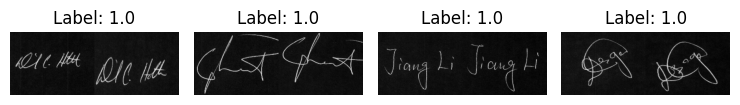

In [ ]:
visualize(X_val[:-1], y_val[:-1], to_show = 4, num_col = 4)

### Visualize test data

Index to show: 3064
Index to show: 1873
Index to show: 4109
Index to show: 5083


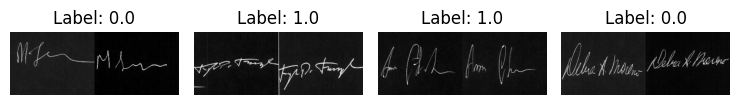

In [ ]:
visualize(X_test[:-1], y_test[:-1], to_show = 4, num_col = 4)

## Siamese Network

In [ ]:
def siamese_network(input_shape):
    input = Input(input_shape)

    x = Rescaling(1/255)(input)

    x = Conv2D(64, (11, 11), activation = "relu")(input)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Conv2D(128, (7, 7), activation = "relu")(x)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), activation = "relu")(x)

    x = Conv2D(512, (3, 3), activation = "relu")(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    x = Dense(128, activation = "relu")(x)

    model = Model(input, x)

    return model

def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    sum_square = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Predictions on test data

In [ ]:
imageA = Input(input_shape)
imageB = Input(input_shape)

siamese = siamese_network(input_shape)

modelA = siamese(imageA)
modelB = siamese(imageB)

distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])

output = Dense(1, activation = "sigmoid")(distance)

model = Model(inputs = [imageA, imageB], outputs = output)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150, 200, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  3530918   ['input_1[0][0]',             
                                                          4          'input_2[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['model[0][0]',      

### Fit a new model

In [ ]:
batch_size = 64
epochs = 20
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1)

history = model.fit([X_train[:, 0, :, :], X_train[:, 1, :, :]], y_train,
                    validation_data = ([X_val[:, 0, :, :], X_val[:, 1, :, :]], y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1)

Epoch 1/20


266/266 [==============================] - 2075s 8s/step - loss: 0.3319 - accuracy: 0.9532 - val_loss: 0.2860 - val_accuracy: 0.9991
Epoch 2/20
266/266 [==============================] - 2028s 8s/step - loss: 0.2599 - accuracy: 0.9995 - val_loss: 0.2368 - val_accuracy: 0.9991
Epoch 3/20
266/266 [==============================] - 2022s 8s/step - loss: 0.2157 - accuracy: 0.9996 - val_loss: 0.1974 - val_accuracy: 0.9991
Epoch 4/20
266/266 [==============================] - 2023s 8s/step - loss: 0.1802 - accuracy: 0.9996 - val_loss: 0.1657 - val_accuracy: 0.9991
Epoch 5/20
266/266 [==============================] - 2025s 8s/step - loss: 0.1517 - accuracy: 0.9996 - val_loss: 0.1401 - val_accuracy: 0.9991
Epoch 6/20
266/266 [==============================] - 2030s 8s/step - loss: 0.1384 - accuracy: 0.9936 - val_loss: 0.1236 - val_accuracy: 0.9965
Epoch 7/20
266/266 [==============================] - 2026s 8s/step - loss: 0.1232 - accuracy: 0.9921 - val_loss: 0.1020 - val_accurac

In [ ]:
model.save("siamese_model.keras")
model.save("siamese_model.h5")

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plot loss and accuracy

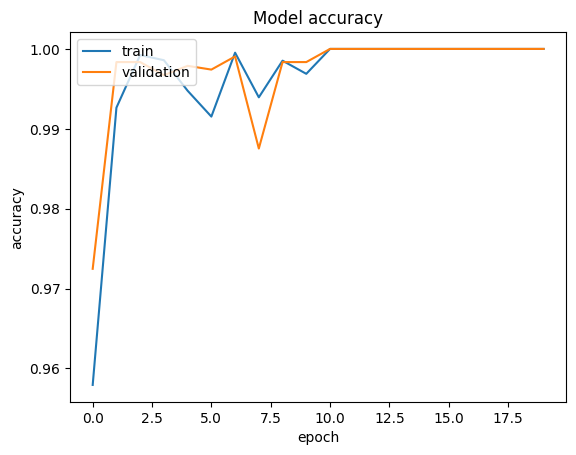

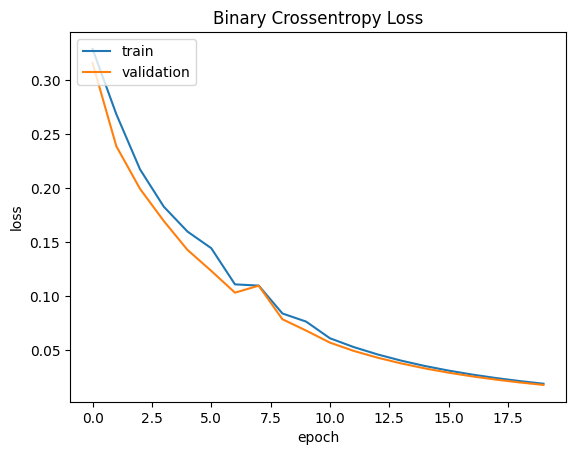

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the loss
plt_metric(history=history.history, metric="loss", title="Binary Crossentropy Loss")


## Evaluation and predictions on Real-Test data

In [ ]:
print(model.input_shape)

[(None, 150, 200, 1), (None, 150, 200, 1)]


Loading the real signatures dataset (*X_test_siam.npy, y_test_siam.npy*), which has been preprocessed using the make-pairs.ipynb file in the same way as the model's training dataset.

In [ ]:
# Load Test Data
X_test_siam = np.load("X_test_siam.npy", allow_pickle=True)
y_test_siam = np.load("y_test_siam.npy", allow_pickle=True)

print("X_test_siam shape:", X_test_siam.shape) 

# Split into two separate inputs for the Siamese Network
X_test_A = X_test_siam[:, 0, :, :]  # First image in the pair
X_test_B = X_test_siam[:, 1, :, :]  # Second image in the pair

print("X_test_A shape:", X_test_A.shape) 
print("X_test_B shape:", X_test_B.shape)  


X_test_A = X_test_A.reshape(-1, 150, 200, 1)
X_test_B = X_test_B.reshape(-1, 150, 200, 1)

print("Reshaped X_test_A:", X_test_A.shape) 
print("Reshaped X_test_B:", X_test_B.shape) 

# Evaluate Model on Test Data
results = model.evaluate([X_test_A, X_test_B], y_test_siam)
print("Test Loss, Test Accuracy:", results)

X_test_siam shape: (6072, 2, 150, 200)
X_test_A shape: (6072, 150, 200)
X_test_B shape: (6072, 150, 200)
Reshaped X_test_A: (6072, 150, 200, 1)
Reshaped X_test_B: (6072, 150, 200, 1)
190/190 [==============================] - 234s 1s/step - loss: 365.2242 - accuracy: 0.4998
Test Loss, Test Accuracy: [365.22418212890625, 0.4998353123664856]


190/190 [==============================] - 235s 1s/step
Index to show: 4183
Index to show: 3890
Index to show: 4627


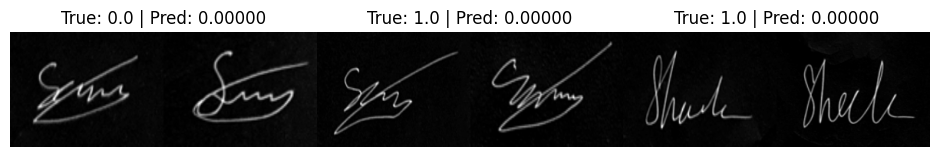

In [ ]:
# Make Predictions
predictions = model.predict([X_test_A, X_test_B])

# Visualize Predictions (if `visualize` function exists)
visualize(X_test_siam[:-1], y_test_siam[:-1], to_show=3, predictions=predictions, test=True)